# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 20 November 2023**

# Notebook 2. Negative Labels Upsampling using OpenAI API  

### 2.0. Introduction

My EDA of the labelled dataset described in the Notebook 1 highlighted a serious shortage of the negatively labelled comments/messages (only 1.6% of the data).  When I tried to run my modelling using such deeply imbalanced dataset I wasn’t getting good results on recall and precision for a minority class. Therefore, **I decided to use open Ai’s GPT models as a substitute for human labelling**.  I used GPT 3.5 as a first labeller, and then I used GPT-4 model as a second "pair of eyes", so to say, to label my dataset. The process is detailed in this notebook in the code below, and it can be summarised as follows: 

1. I used a large dataset of Reddit WallStreetBets posts from 2021 as my source of text/posts.  The dataset is described in detail in my project Notebook 4. In short, it is a large dataset of finance related subreddits posts collected in 2021.  The source of the dataset is here: https://www.kaggle.com/datasets/leukipp/reddit-finance-data.  See my Notebook 4 for a full description.  I will refer to this dataset as "the Reddit dataset" throughout my notebooks (to distinguish it from the small “labelled dataset” described in the Notebook 1). 

2. I loaded the Reddit dataset and filtered out those rows that has empty text fields, too long and too short messages, and concentrated on the period after March 2021, when the bullishness that prevailed in 1Q 2021 has somewhat subsided. I thought that probability of finding negative/bearish messages was higher once we exclude an extremely bullish period of Q1 2021. 

3. I selected a portion of the large Reddit dataset to send to OpenAI API accompanied with a prompt to rate it as expressing bullish or bearish views on securities. 

4. I collected GPT 3.5 responses and filtered out all but negatively rated messages.  

5. I then fed the negative only messages to GPT 4 model, using the same prompt, and collected its ratings. 

6. I kept only those messages where both models "agreed" that the message was bearish/negative with respect to the securities mentioned in its text. 

The final result of this process was saved as a CSV file. 

The table below describes the process in detail:

| Description | Rows after this step | % of starting rows kept | % of starting rows deleted at this step |
|-------------|----------------------:|-----------------------:|---------------------------------------:|
| Data load | 1,260,374 | 100.00% | |
| rows where 'link_flair_text' is irrelevant | 1,246,161 | 98.87% | -1.1% |
| rows where 'title' starts with 'Daily ' | 1,245,087 | 98.79% | -0.1% |
| rows where 'selftext' is '[removed]' | 618,703 | 49.09% | -49.7% |
| rows where 'date' is before April 1, 2021 | 256,656 | 20.36% | -28.7% |
| rows where token_count is greater than 400 | 241,354 | 19.15% | -1.2% |
| rows where token_count is smaller than 20 | 111,183 | 8.82% | -10.3% |
| some rows processed with Chat GPT 3.5 API | 3,648 | 0.29% | -8.5% |
| only "Negative" ratings fed back to GPT 4 | 725 | 0.06% | -0.2% |
| rows where both GPT model ratings are 'negative' | 450 | 0.04% | 0.0% |

I hoped to process more data using GPT models, however, GPT 3.5 model was very slow when I tried to do it, so I was limited to 450 negative messages after 2 full days of trying to label more data. I think this was a sufficient number of rows to start training my models.  This process can be continued, once the initial results are formulated, in order to improve overall model quality.



### 2.1. Generating more negative class labels using Chat GPT 

In [3]:
import os
import time

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import openai

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
openai.api_key = os.getenv('OPENAI_API_KEY')

In [3]:
# Read in data
df_all = pd.read_csv('../data/reddit_cleaned_slim.csv')
print(df_all.shape)
# df = df.head(9)
#print(df.shape)

(1260374, 18)


### 2.2. Eliminating rows and columns that are not relevant to investing and stock trading

In [4]:
# Getting frequency counts for 'FolderName'
folder_name_counts = df_all['FolderName'].value_counts()

# Displaying the frequency counts
print(folder_name_counts)

FolderName
wallstreetbets          719899
gme                     268376
stocks                   68524
pennystocks              50712
stockmarket              41388
investing                38162
options                  27965
robinhoodpennystocks     21235
robinhood                17564
finance                   6549
Name: count, dtype: int64


In [5]:
# Filter out rows where 'link_flair_text' is irrelevant

# List of irrelevant flair texts
irrelevant_flairs = ['Credit', 'Taxes', 'Other', 'Housing', 'Retirement', 'Planning', 'Saving', 'Debt', 'Auto', 'Employment', 'Insurance', "Budgeting", "Advice", 'Advice Request']

# Filter out rows where 'link_flair_text' is in the list of irrelevant flairs
df_all = df_all[~df_all['link_flair_text'].isin(irrelevant_flairs)].copy()
print(df_all.shape)

(1246161, 18)


In [6]:
# Convert 'title' column to string
df_all['title'] = df_all['title'].astype(str)

# Filter out rows where 'title' starts with 'Daily '
df_all = df_all[~df_all['title'].str.startswith('Daily ')].copy()
print(df_all.shape)

(1245087, 18)


#### 2.2.1. Optional filters (untoggle as needed)

In [7]:
# Filter out rows where 'selftext' is '[removed]'
#df_all = df_all[df_all['selftext'] != '[removed]'].copy()
#df_all = df_all[df_all['selftext'] != '[deleted]'].copy()
print(df_all.shape)

(618703, 18)


In [8]:
# Convert 'date' column to datetime
df_all['date'] = pd.to_datetime(df_all['date'])

In [9]:
# Filter rows where 'date' is before April 1, 2021
df_all = df_all[df_all['date'] > '2021-04-01'].copy()
print(df_all.shape)

(256656, 18)


In [16]:
# Select rows containing "GME", "Gamestop", or "$GME" in the 'Text' column
df = df[df['Text'].str.contains(r'GME|Gamestop|\$GME', case=False, regex=True)].copy()

### 2.3. Only keeping the text fields in a smaller dataframe df

In [10]:
# Selecting only the 'id', 'title', and 'selftext' columns
df = df_all[['id', 'title', 'selftext']].copy()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28730 entries, 46 to 1048971
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28730 non-null  object
 1   title        28730 non-null  object
 2   selftext     13489 non-null  object
 3   Text         28730 non-null  object
 4   token_count  28730 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [30]:
df.sample(5)

,id,title,selftext
473088,rcykn5,Why invest in Liberty Oilfield Services?,[removed]
401438,qfmagt,Blackberry shares thoughts?,[removed]
792572,nuhd4n,To the moon!!,NaN
197229,mx0jcm,It’s going to happen,NaN
990785,mkbmic,Easter & Egg Hunting with the Fam was fun.. Ok...,NaN


In [13]:
# Concatenating 'title' and 'selftext' with a comma separator
df['Text'] = df.apply(lambda row: f"{row['title']}, {row['selftext']}", axis=1)

# Displaying the first few rows of the new concatenated column
print(df[['id', 'Text']].head())

         id                                               Text
46   msblc3  GME YOLO update — Apr 16 2021 — final update, nan
69   pu7l07  What Are Your Moves Tomorrow, September 24, 20...
87   mqp6lv  COIN IPO Megathread 4/14/2021, This is a megat...
155  pk8tne  For anyone who doesn’t understand why Hedgefon...
158  nuxr2t  r/GME Megathread for Tuesday - June 08, 2021, ...


### 2.4. Eliminating lengthy messages (too expensive for chat GPT processing)

In [22]:
from transformers import GPT2Tokenizer

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Function to estimate tokens
def estimate_tokens(text):
    return len(tokenizer.encode(text))

# Applying the function to your dataframe
df['token_count'] = df['Text'].apply(estimate_tokens)

NameError: name 'df' is not defined

In [15]:
long_rows = df[df['token_count'] > 400]
long_rows.sample(5)

,id,title,selftext,Text,token_count
968630,qipv5n,Posts about posts fud,You've seen it many times if you've been here ...,"Posts about posts fud, You've seen it many tim...",1257
29775,nzsghf,"AMD - constantly outperforming, constantly und...",\n**Basics**\n\nAs long as you haven't been li...,"AMD - constantly outperforming, constantly und...",869
19587,oeas8a,Intel (INTC) stock prospects: are you bullish ...,I bought INTC when I first started investing a...,Intel (INTC) stock prospects: are you bullish ...,260
9015,o6j2an,Ken Griffin has become the scapegoat for the f...,"Wrinkle brains and reddit detectives, I need y...",Ken Griffin has become the scapegoat for the f...,712
12474,pres5t,"Evergrande FUD, What the China property market...",From [r/baba](www.reddit.com/r/baba):\n\nThere...,"Evergrande FUD, What the China property market...",657


In [28]:
short_rows = df[df['token_count'] < 20]
short_rows.sample(5)

,id,title,selftext,Text,token_count
18918,o5xlff,HODL GME my new plates waiting for the Lambo now.,NaN,HODL GME my new plates waiting for the Lambo n...,16
18204,ner6w3,GME 101 w/ Marantz Rantz,NaN,"GME 101 w/ Marantz Rantz, nan",11
20760,qsedhb,Told parents to buy GME multiple times before…,NaN,Told parents to buy GME multiple times before…...,13
20645,qiuoj9,Perhaps Dr. Burry works for GameStop’s Twitter...,NaN,Perhaps Dr. Burry works for GameStop’s Twitter...,17
12550,r06rwd,"GameStop will print, test 260 get ready!",NaN,"GameStop will print, test 260 get ready!, nan",11


In [18]:
# Dropping rows where token_count is greater than 400
df = df[df['token_count'] <= 400].reset_index(drop=True)
print(df.shape)

(21410, 5)


In [22]:
# Dropping rows where token_count is smaller than 20
df = df[df['token_count'] > 20].reset_index(drop=True)
print(df.shape)

(21271, 5)


In [23]:
token_total = df['token_count'].agg("sum")
print(token_total)

1047792


In [24]:
token_average = df['token_count'].agg("median")
print(token_average)

30.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21271 entries, 0 to 21270
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           21271 non-null  object
 1   title        21271 non-null  object
 2   selftext     6173 non-null   object
 3   Text         21271 non-null  object
 4   token_count  21271 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 831.0+ KB


In [57]:
# df.drop(df.index[0:180], inplace=True)

In [55]:
df.shape

(15762, 5)

### 2.5. Messages fed to GPT 3.5 model

The code below was written with the help of Chat GPT, as I wasn’t able to navigate all the complexities of the OpenAi API on my own.  In particular, I struggled with the throttling of API requests, and I could not figure out how to slow down the requests (number of API requests per minute), so Chat GPT was used to add the throttling function and the batch processing function.  

The code was designed to analyse sentiment in Reddit messages selected above. 

1) The ask_gpt function sends text to the GPT-3.5 model and returns its response, handling exceptions if they occur. 
2) The throttled_request function includes a delay between requests. 
3) The main function, process_batch, processes data in small batches (only several rows at a time, in case the system becomes non-responsive). The function sends a prompt to GPT model and the response is a sentiment tag 'Positive', 'Negative', or 'Unclear'.  
4) The results are then saved to a CSV file in batches, with the ability to append results. 



In [56]:
# Function to send text to GPT-4 and receive sentiment tag
openai.api_key = "MY_OPENAI_KEY"

def ask_gpt(text):
    try:
        # Sending the prompt to the ChatGPT model and getting the response
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo", 
            messages=[{"role": "system", "content": "You are a helpful assistant."}, 
                      {"role": "user", "content": text}]
        )
        # Returning the text of the response
        return response.choices[0].message['content'].strip()
    except Exception as e:
        print(f"An error occurred: {e}")
        return "Error"

def throttled_request(text, delay=1.0):
    response = ask_gpt(text)
    time.sleep(delay)
    return response

# Function to process a batch and append results to a CSV file
def process_batch(df, batch_size, csv_file):
    start = 0
    while start < len(df):
        end = min(start + batch_size, len(df))
        batch = df.iloc[start:end].copy()
        batch['Sentiment_Tag'] = batch['Text'].apply(lambda text: throttled_request(f"""
You will be presented with a Reddit message and your job is to provide in return a sentiment tag: 
choose either the “Positive” OR “Negative” OR “Unclear” tag but NOT several. 
Assess the sentiment of a Reddit message concerning shares, identified by company names or stock tickers. 
Focus exclusively on sentiments about the shares' performance, not the overall business performance. 
Evaluate the entire post. 
Classify the sentiment as 'Positive' for actions like buying calls, holding call options, or selling put options; 
'Negative' for buying puts, holding put options, or selling call options; 
and 'Unclear' for neutral, mixed, conflicting sentiments, or unclear mentions. 
Return back a tag with a sentiment concerning the shares. Choose tags ONLY from the list of tags provided above. 
Provide in response just a tag without an explanation.
Message: {text}"""))
        # Append batch results to CSV file
        if start == 0:
            batch.to_csv(csv_file, mode='w', header=True, index=False)  
        else:
            batch.to_csv(csv_file, mode='a', header=False, index=False)  
        
        start += batch_size
        print(f"Processed batch {start // batch_size} of {len(df) // batch_size}")

# Parameters
batch_size = 3  
csv_file = '../data/wsb_sentiment_results.csv'

# Process the DataFrame in batches
process_batch(df, batch_size, csv_file)

print("Processing complete.")

Processed batch 1 of 5254
Processed batch 2 of 5254
An error occurred: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Processed batch 3 of 5254
Processed batch 4 of 5254
Processed batch 5 of 5254
Processed batch 6 of 5254
Processed batch 7 of 5254
Processed batch 8 of 5254
Processed batch 9 of 5254
Processed batch 10 of 5254
Processed batch 11 of 5254
Processed batch 12 of 5254
An error occurred: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Processed batch 13 of 5254
Processed batch 14 of 5254
An error occurred: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Processed batch 15 of 5254
Processed batch 16 of 5254
Processed batch 17 of 5254
Processed batch 18 of 5254
Processed batch 19 of 5254
An error occurred: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}

KeyboardInterrupt: 

### 2.6. GPT-4 repeat labelling 

In [4]:
# Read in data saved in a csv file in the previoius step
file_path = '../data/wsb_sentiment_results.csv'
df_check = pd.read_csv(file_path)

print(df_check.shape)

(3648, 8)


As a resut of partial processing of the Reddit unlabelled messages with Chat GPT 3.5 API I have accumulated 3648 rows.

In [89]:
# Set maximum column width to None to display full text content
pd.set_option('display.max_colwidth', None)
df_check.head(2)

,id,title,selftext,Text,token_count,Sentiment_Tag,Unnamed: 6,Unnamed: 7
0,mqp6lv,COIN IPO Megathread 4/14/2021,"This is a megathread for the $COIN IPO. We will allow discussion of the COIN stock, but do note that the no crypto rule still applies. If you use COIN as a proxy to discuss crypto, instead of discussing the stock, you will be banned. Itâs a bit of a gray line, so ensure that you keep discussion focused on the stock.\n\n\nEdit: Direct Listing*","COIN IPO Megathread 4/14/2021, This is a megathread for the $COIN IPO. We will allow discussion of the COIN stock, but do note that the no crypto rule still applies. If you use COIN as a proxy to discuss crypto, instead of discussing the stock, you will be banned. Itâs a bit of a gray line, so ensure that you keep discussion focused on the stock.\n\n\nEdit: Direct Listing*",103,Unclear,NaN,NaN
1,pk8tne,"For anyone who doesnât understand why Hedgefonds lost, this ape explained it well.",NaN,"For anyone who doesnât understand why Hedgefonds lost, this ape explained it well., nan",21,Unclear,NaN,NaN


In [90]:
# Getting frequency counts for 'Sentiment_Tag'
tag_counts = df_check['Sentiment_Tag'].value_counts()

# Displaying the frequency counts
print(tag_counts)

Sentiment_Tag
Unclear     1545
Positive    1171
Negative     725
Error        203
Neutral        4
Name: count, dtype: int64


In [91]:
df_check = df_check[df_check['Sentiment_Tag'] != 'Error'].copy()
df_check = df_check[df_check['Sentiment_Tag'] != 'Unclear'].copy()
df_check = df_check[df_check['Sentiment_Tag'] != 'Positive'].copy()
df_check = df_check[df_check['Sentiment_Tag'] != 'Neutral'].copy()
df_check.shape

(725, 8)

In total, I have 725 negative ratings, or 20% of the data given to GPT 3.5 (first "set of eyes"). This percentage seems to be reasonable and consistent with my expectations. 

When I review the quality of the GPT 3.5 ratings, I notice that while many of them are correct, not all of them are perfectly on point.  Some ratings I disagree with. In order to increase my confidence in having good quality ratings, I decided to screen them again, using a different GPT model (GPT 4). 

In the code below I am re-checking the negative ratings from the previous step with GPT-4, a more advanced model (also more expensive to process tokens). I essentially treat GPT-4 model as a second set of eyes (as another human) to confirm the ratings given to me by Chat GPT 3.5 model.  I record the results of GPT-4 model processing in a new column Sentiment_Tag_2, in batches, in a new csv file. 

For my negative ratings up sampling I will select only those that were rated as "negative" by both models. 

The code below is a replica of the code used in teh previous section, but with GPT-4 model, not GPT 3.5 as before: 


In [62]:
# Function to send text to GPT-4 and receive sentiment tag (you need to implement this)
openai.api_key = "MY_OPENAI_KEY"

def ask_gpt(text):
    try:
        # Sending the prompt to the ChatGPT model and getting the response
        response = openai.ChatCompletion.create(
            model="gpt-4",  
            messages=[{"role": "system", "content": "You are a helpful assistant."}, 
                      {"role": "user", "content": text}]
        )
        # Returning the text of the response
        return response.choices[0].message['content'].strip()
    except Exception as e:
        print(f"An error occurred: {e}")
        return "Error"

def throttled_request(text, delay=5.0):
    response = ask_gpt(text)
    time.sleep(delay)
    return response

# Function to process a batch and append results to a CSV file
def process_batch(df, batch_size, csv_file):
    start = 0
    while start < len(df):
        end = min(start + batch_size, len(df))
        batch = df.iloc[start:end].copy()  
        batch['Sentiment_Tag_2'] = batch['Text'].apply(lambda text: throttled_request(f"""You will be presented with a Reddit message and your job is to provide in return a sentiment tag: choose either the “Positive” OR “Negative” OR “Unclear” tag but NOT several). 
Assess the sentiment of a Reddit message concerning shares, identified by company names or stock tickers. 
Focus exclusively on sentiments about the shares' performance, not the overall business performance. Evaluate the entire post. 
Classify the sentiment as 'Positive' for actions like buying calls, holding call options, or selling put options; 
'Negative' for buying puts, holding put options, or selling call options; 
and 'Unclear' for neutral, mixed, conflicting sentiments, or unclear mentions. 
Return back a tag with a sentiment concerning the shares. Choose tags ONLY from the list of tags provided above. 
Provide in response just a tag without an explanation.
Message: {text}"""))
        # Append batch results to CSV file
        if start == 0:
            batch.to_csv(csv_file, mode='w', header=True, index=False)  
        else:
            batch.to_csv(csv_file, mode='a', header=False, index=False)  
        
        start += batch_size
        print(f"Processed batch {start // batch_size} of {len(df) // batch_size}")

# Parameters
batch_size = 150  
csv_file = '../data/wsb_sentiment_results_check.csv'

# Process the DataFrame in batches
process_batch(df_check, batch_size, csv_file)

print("Processing complete.")

Processed batch 1 of 4
Processed batch 2 of 4
Processed batch 3 of 4
Processed batch 4 of 4
Processed batch 5 of 4
Processing complete.


### 2.7. Re-checking the chat GPT-4 ratings and comparing two GPT model outputs

In [6]:
# Read in data
df_check_gpt4 = pd.read_csv('../data/wsb_sentiment_results_check.csv')
print(df_check_gpt4.shape)
# df = df.head(9)
#print(df.shape)

(725, 7)


In [7]:
df_check_gpt4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               725 non-null    object
 1   title            725 non-null    object
 2   selftext         464 non-null    object
 3   Text             725 non-null    object
 4   token_count      725 non-null    int64 
 5   Sentiment_Tag    725 non-null    object
 6   Sentiment_Tag_2  725 non-null    object
dtypes: int64(1), object(6)
memory usage: 39.8+ KB


Having a look at the new ratings (see new column Sentriment_Tag_2),  anc comparing the output of two GPT models:

In [10]:
df_check_gpt4.sample(5)

,id,title,selftext,Text,token_count,Sentiment_Tag,Sentiment_Tag_2
402,m0iyjz,$RKT Puts,Today my puts randomly changed prices. Is this...,"$RKT Puts, Today my puts randomly changed pric...",28,Negative,Negative
370,mq7yi5,SPY puts,[spy](https://i.postimg.cc/j20LdVxJ/FEF3-A80-B...,"SPY puts, [spy](https://i.postimg.cc/j20LdVxJ/...",150,Negative,Negative
377,mqe8ox,XL Puts 4/16,I know its very risky but i feel like its a sa...,"XL Puts 4/16, I know its very risky but i feel...",29,Negative,Negative
560,nk6jum,They refuse to let GME close above $180. WTH,Where are they getting all these shares to sho...,"They refuse to let GME close above $180. WTH, ...",152,Negative,Positive
701,mlp05i,She looks hungry for some shorts tomorrow 🍌🚀🤨 ...,NaN,She looks hungry for some shorts tomorrow 🍌🚀🤨 ...,21,Negative,Positive


In [115]:
# Getting frequency counts for 'Sentiment_Tag'
tag_counts = df_check_gpt4['Sentiment_Tag_2'].value_counts()

# Displaying the frequency counts
print(tag_counts)
df_check_gpt4.shape

Sentiment_Tag_2
Negative    450
Unclear     208
Positive     67
Name: count, dtype: int64


(725, 7)

There is a considerable degree of disagreement between the two GPT models. 

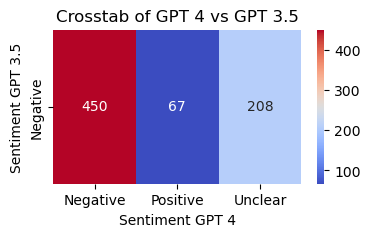

In [24]:
# Create a crosstab of the two columns
crosstab_result = pd.crosstab(df_check_gpt4['Sentiment_Tag'], df_check_gpt4['Sentiment_Tag_2'])

# Plotting the crosstab
plt.figure(figsize=(4, 2))  
sns.heatmap(crosstab_result, annot=True, fmt="d", cmap="coolwarm")  # 'fmt' is format of the annotation (integer in this case)

# Adding titles and labels
plt.title('Crosstab of GPT 4 vs GPT 3.5')
plt.xlabel('Sentiment GPT 4')
plt.ylabel('Sentiment GPT 3.5')

# Display the plot
plt.show()

450 rows weer rated as "negative" by both GPT models.  This is 62% of the starting number of rows rated as negative by Chat GPT 3.5 (725 rows).  In 9% of cases Chat GPT 4 completely disagreed with the negative rating given by Chat GPT 3.5 and assigned "positive" rating to the text. 

**Conclusion**:  I will treat those instances where both Chat GPT models agreed that the rating was "negative" as the additional "ground truth" for my model training.  This will help to address the deficit of negative ratings in the labelled dataset and will help in training my models.

In [116]:
# Deleting rows where two GPT models disagree with each other. Keeping only those rows where both ratings are "negative"
df_check_gpt4 = df_check_gpt4[df_check_gpt4['Sentiment_Tag_2'] != 'Unclear'].copy()
df_check_gpt4.reset_index(drop=True, inplace=True)

df_check_gpt4 = df_check_gpt4[df_check_gpt4['Sentiment_Tag_2'] != 'Positive'].copy()
df_check_gpt4.reset_index(drop=True, inplace=True)

print(df_check_gpt4.shape)


(450, 7)


### 2.8. Cleaning the newly generated negative reviews

In the code below I repeat the same cleaning steps as in the notbook 01 Labelled EDA and Cleaning, to ensure pre-processing consistency: 

* checking for missing values and duplicates
* removing website inks (urls), hashtags (#) and mentions (@)
* the resulting dataset is then saved into a csv file

In [117]:
df_check_gpt4[ df_check_gpt4['Text'].isna() ]

,id,title,selftext,Text,token_count,Sentiment_Tag,Sentiment_Tag_2


In [118]:
df_check_gpt4[df_check_gpt4['Text'].isna() ]

,id,title,selftext,Text,token_count,Sentiment_Tag,Sentiment_Tag_2


In [119]:
df_clean = df_check_gpt4.copy()
df_clean.reset_index(drop=True, inplace=True)

In [120]:
# Function to clean text
def purge_content(text):
    text_without_urls = re.sub(r'https?://\S+|www\.\S+', '', text)
    text_without_hashtags = re.sub(r'#\S+', '', text_without_urls)
    text_without_mentions = re.sub(r'@\S+', '', text_without_hashtags)
    text_without_linebreaks = re.sub(r'\n+', '', text_without_mentions)
    clean_text = re.sub(r'\n+', ' ', text_without_linebreaks)

    return clean_text

In [121]:
# Using apply() method to clean the text
df_clean['Text'] = df_clean['Text'].apply(purge_content)

In [122]:
df_clean.sample(3)

,id,title,selftext,Text,token_count,Sentiment_Tag,Sentiment_Tag_2
221,m2jt64,To my best friend who experienced his first loss,(Disclaimer: This is my humble opinion about t...,To my best friend who experienced his first lo...,1061,Negative,Negative
128,nchd2q,I promised you an update after earnings... And...,NaN,I promised you an update after earnings... And...,64,Negative,Negative
141,r0sqxy,PLTR CEO on CNBC convinced me that I need to b...,I have been using PLTR for the wheel strategy ...,PLTR CEO on CNBC convinced me that I need to b...,233,Negative,Negative


### 2.9. Saving the cleaned dataframe into a CSV file for further steps in modelling

In [125]:
# Save the DataFrame to a CSV file
df_clean.to_csv('../data/reddit_gpt4_negative_only_cleaned.csv', index=False)

### 2.10. Conclusions

* I have identified 450 additional negative intentions messages.  
* 3.6 thousands messages fed to two GPT models yielded 450 double labelled negative messages. 
* Total cost - around $12.  
* The main limiting factor was time, as GPT 3.5 API is very slow and prone to freezing up and crashing.  

I will use the newly labelled messages to upsample my imbalaned labelled dataset.